# Adaboost多分类原理展示

## 导包

In [1]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz

## 加载数据

In [2]:
X,y = datasets.load_iris(return_X_y=True)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1024)

## 建模

In [3]:
ada = AdaBoostClassifier(n_estimators=3,algorithm='SAMME',learning_rate=1.0)

ada.fit(X_train,y_train) # 建模，学习

y_ = ada.predict(X_test)

proba_ = ada.predict_proba(X_test)
print('分类准确率：',ada.score(X_test,y_test))
display(y_,proba_)

分类准确率： 0.9666666666666667


array([1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 2, 0,
       1, 0, 2, 1, 2, 2, 2, 2])

array([[0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.2796265 , 0.38881125, 0.33156225],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2796265 , 0.38881125, 0.33156225],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.

#  构建第一棵树

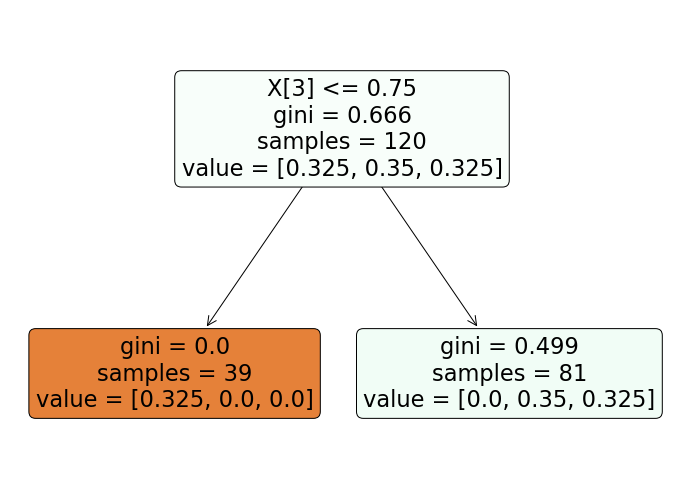

In [5]:
# dot_data = tree.export_graphviz(ada[0],filled=True,rounded=True)
# graphviz.Source(dot_data)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,9))
_ = tree.plot_tree(ada[0],filled=1,rounded=1)

## gini系数

In [6]:
w1 = np.full(shape = 120,fill_value=1/120) # 每个样本的权重

gini = 1

for i in range(3):# 三类，0,1,2
    # 计算每个类别的概率
    cond = y_train == i # 判断类别
    
    p = w1[cond].sum() # 这一类样本的权重
    
    gini -= p**2
print(gini)

0.6662499999999998


## 拆分条件

In [7]:
X_train.shape # 特征数量

(120, 4)

In [8]:
best_split = {} # 放最佳的裂分条件
lower_gini = 1 # 标志，用于判断最小的gini系数

# 如何划分呢，分成两部分
for col in range(X_train.shape[1]): # 4个特征，选哪个特征进行分裂？
    for i in range(len(X_train) - 1): # 具体特征，选哪个裂分点
        
        X = X_train[:,col].copy() # 取出某个特征
        X.sort() # 排序，从小到大
        
        # 切片，求平均值，裂分点
        split = X[i:i+2].mean()
        
        cond = (X_train[:,col] <= split).ravel() # 条件判断
        
        # 左右两部分
        left = y_train[cond]
        right = y_train[~cond]
        
        # 左右两边的gini系数，分别计算
        gini_left = 0
        gini_right = 0
        for target in range(3): # 0、1、2
            p1 = (left == target).sum()/left.size # 左边类别的概率
            gini_left += p1 * (1 - p1)
            if right.size != 0:
                p2 = (right == target).sum()/right.size # 右边类别的概率
                gini_right += p2 * (1 - p2)
            
        left_p = w1[cond].sum() # 左边部分占整体的概率
        right_p = 1 - left_p # 就分两部分
        
        # 整合左右两边的gini系数
        gini  = left_p * gini_left + right_p * gini_right
        
        # 标志判断最小的gini
        if gini < lower_gini: # 根据某个裂分条件，计算的gini是不是小
            lower_gini = gini
            best_split.clear()
            best_split['X[%d]'%(col)] = split
        elif gini == lower_gini: # 并列第一
            best_split['X[%d]'%(col)] = split
print(best_split)

{'X[2]': 2.5999999999999996, 'X[3]': 0.75}


## 计算误差率

In [9]:
# 计算误差率
y1_ = ada[0].predict(X_train) #预测结果

print(y1_)
e1 = ((y_train != y1_)).mean()#误差
print('第一棵树误差率是：',e1)
print('算法的误差是：',ada.estimator_errors_)

[1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1
 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1]
第一棵树误差率是： 0.325
算法的误差是： [0.325      0.18993352 0.1160323 ]


## 计算弱学习器权重

In [10]:
np.log(2 -1)

0.0

In [11]:
learning_rate = 1.0
num = 3 # 三分类：0、1、2

a1 = learning_rate * (np.log((1-e1)/e1) + np.log(num - 1))

print('手动计算算法权重是：',a1)

print('算法返回的分类器权重是：',ada.estimator_weights_)

手动计算算法权重是： 1.4240346891027378
算法返回的分类器权重是： [1.42403469 2.14358936 2.72369906]


## 更新权重

In [12]:
# 更新样本的权重
w2 = w1 * np.exp(a1 * (y_train != y1_))
w2 /= w2.sum() # 归一化
w2

array([0.00411523, 0.01709402, 0.01709402, 0.01709402, 0.00411523,
       0.00411523, 0.00411523, 0.00411523, 0.00411523, 0.00411523,
       0.00411523, 0.00411523, 0.00411523, 0.01709402, 0.00411523,
       0.01709402, 0.01709402, 0.00411523, 0.00411523, 0.01709402,
       0.01709402, 0.01709402, 0.00411523, 0.00411523, 0.00411523,
       0.01709402, 0.01709402, 0.00411523, 0.01709402, 0.00411523,
       0.01709402, 0.01709402, 0.00411523, 0.00411523, 0.01709402,
       0.00411523, 0.00411523, 0.01709402, 0.00411523, 0.00411523,
       0.00411523, 0.00411523, 0.00411523, 0.00411523, 0.00411523,
       0.00411523, 0.00411523, 0.00411523, 0.00411523, 0.00411523,
       0.00411523, 0.01709402, 0.01709402, 0.01709402, 0.01709402,
       0.00411523, 0.00411523, 0.00411523, 0.00411523, 0.01709402,
       0.01709402, 0.00411523, 0.01709402, 0.01709402, 0.01709402,
       0.00411523, 0.01709402, 0.00411523, 0.00411523, 0.01709402,
       0.00411523, 0.00411523, 0.01709402, 0.00411523, 0.01709

# 构建第二棵树

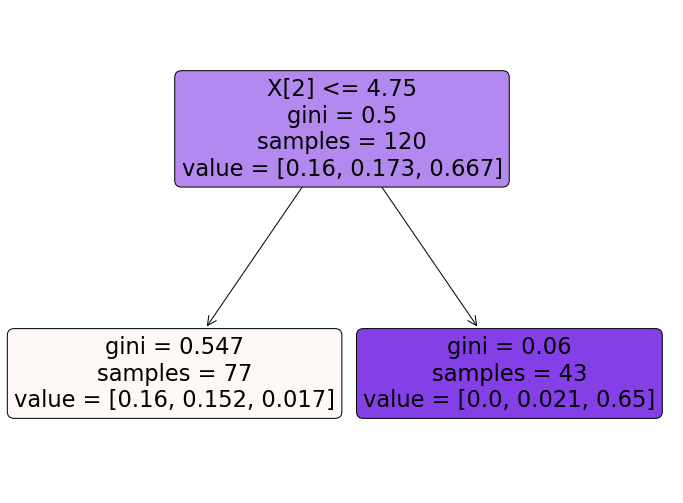

In [13]:
# dot_data = tree.export_graphviz(ada[1],filled=True,rounded=True)
# graphviz.Source(dot_data)
plt.figure(figsize=(12,9))
_ = tree.plot_tree(ada[1],filled=1,rounded=1)

In [14]:
for i in range(3):
    cond = y_train == i
    value = w2[cond].sum()
    print(np.round(value,3))

0.16
0.173
0.667


## gini系数计算

In [15]:
gini = 1

for i in range(3):# 三类，0,1,2
    # 计算每个类别的概率
    cond = y_train == i # 判断类别
    
    p = w2[cond].sum() # 这一类样本的权重
    
    gini -= p**2
print(np.round(gini,3))

0.5


## 拆分条件

In [16]:
best_split = {} # 放最佳的裂分条件
lower_gini = 1 # 标志，用于判断最小的gini系数

# 如何划分呢，分成两部分
for col in range(X_train.shape[1]): # 4个特征，选哪个特征进行分裂？
    for i in range(len(X_train) - 1): # 具体特征，选哪个裂分点
        
        X = X_train[:,col].copy() # 取出某个特征
        X.sort() # 排序，从小到大
        
        # 切片，求平均值，裂分点
        split = X[i:i+2].mean()
        
        cond = (X_train[:,col] <= split).ravel() # 条件判断
        
        # 左右两部分
        left = y_train[cond]
        left_w = w2[cond]/w2[cond].sum() # 左侧内部的权重分布
        
        right = y_train[~cond]
        right_w = w2[~cond]/w2[~cond].sum() # 右侧内部的权重分布
        
        # 左右两边的gini系数，分别计算
        gini_left = 0
        gini_right = 0
        for target in range(3): # 0、1、2
            cond1 = left == target # 类别的判定条件
            p1 = left_w[cond1].sum() # 某个类别概率
            gini_left += p1 * (1 - p1)
            
            cond2 = right == target
            p2 = right_w[cond2].sum() # 某个类别所有的概率
            gini_right += p2 * (1 - p2)
            
        left_p = w2[cond].sum() # 左边部分占整体的概率
        right_p = 1 - left_p # 就分两部分
        
        # 整合左右两边的gini系数
        gini  = left_p * gini_left + right_p * gini_right
        
        # 标志判断最小的gini
        if gini < lower_gini: # 根据某个裂分条件，计算的gini是不是小
            lower_gini = gini
            best_split.clear()
            best_split['X[%d]'%(col)] = split
        elif gini == lower_gini: # 并列第一
            best_split['X[%d]'%(col)] = split
print(best_split)

{'X[2]': 4.75}


## 计算误差率

In [19]:
# 计算误差率
y2_ = ada[1].predict(X_train) #预测结果

print(y2_)
# e2 = ((y_train != y2_)).mean()#误差

cond = y_train != y2_

e2 = w2[cond].sum()

print('第一棵树误差率是：',e2)
print('算法的误差是：',ada.estimator_errors_)

[0 2 2 2 0 2 0 0 0 0 0 0 0 2 0 2 2 0 0 2 2 2 0 0 0 2 2 0 2 0 2 2 0 0 2 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 2 2 0 2 2 2 0 0 0 0 2 0 0 2 0
 2 0 0 0 0 0 2 0 0 0 2 0 2 2 2 0 2 2 0 2 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 2 2 0 2 0 2]
第一棵树误差率是： 0.1899335232668566
算法的误差是： [0.325      0.18993352 0.1160323 ]


## 计算弱学习器权重

In [20]:
learning_rate = 1.0
num = 3 # 三分类：0、1、2

a2 = learning_rate * (np.log((1-e2)/e2) + np.log(num - 1))

print('手动计算算法权重是：',a2)

print('算法返回的分类器权重是：',ada.estimator_weights_)

手动计算算法权重是： 2.1435893615035875
算法返回的分类器权重是： [1.42403469 2.14358936 2.72369906]


## 更新权重

In [21]:
# 更新样本的权重
w3 = w2 * np.exp(a2 * (y_train != y2_))
w3 /= w3.sum() # 归一化
w3

array([0.01444444, 0.007034  , 0.007034  , 0.007034  , 0.01444444,
       0.01444444, 0.01444444, 0.01444444, 0.00169337, 0.01444444,
       0.01444444, 0.01444444, 0.00169337, 0.007034  , 0.00169337,
       0.007034  , 0.007034  , 0.00169337, 0.01444444, 0.007034  ,
       0.007034  , 0.007034  , 0.00169337, 0.00169337, 0.01444444,
       0.007034  , 0.007034  , 0.01444444, 0.007034  , 0.01444444,
       0.007034  , 0.007034  , 0.01444444, 0.01444444, 0.007034  ,
       0.00169337, 0.00169337, 0.007034  , 0.00169337, 0.01444444,
       0.00169337, 0.01444444, 0.00169337, 0.01444444, 0.01444444,
       0.01444444, 0.00169337, 0.01444444, 0.00169337, 0.01444444,
       0.00169337, 0.007034  , 0.007034  , 0.007034  , 0.007034  ,
       0.01444444, 0.00169337, 0.01444444, 0.00169337, 0.007034  ,
       0.007034  , 0.00169337, 0.007034  , 0.007034  , 0.007034  ,
       0.01444444, 0.06      , 0.01444444, 0.00169337, 0.007034  ,
       0.00169337, 0.00169337, 0.007034  , 0.01444444, 0.00703

# 构建第三棵树

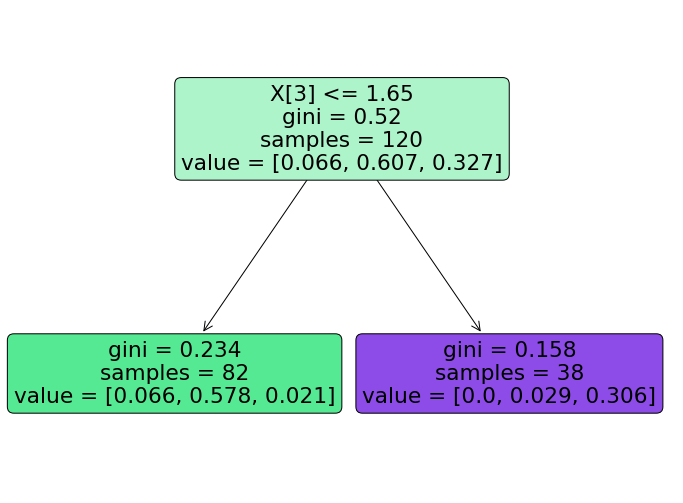

In [22]:
# dot_data = tree.export_graphviz(ada[2],filled=True,rounded=True)
# graphviz.Source(dot_data)
plt.figure(figsize=(12,9))
_ = tree.plot_tree(ada[2],filled=1,rounded=1)

## gini系数计算

In [23]:
gini = 1

for i in range(3):# 三类，0,1,2
    # 计算每个类别的概率
    cond = y_train == i # 判断类别
    
    p = w3[cond].sum() # 这一类样本的权重
    
    gini -= p**2
print(np.round(gini,3))

0.52


## 拆分条件

In [24]:
best_split = {} # 放最佳的裂分条件
lower_gini = 1 # 标志，用于判断最小的gini系数

# 如何划分呢，分成两部分
for col in range(X_train.shape[1]): # 4个特征，选哪个特征进行分裂？
    for i in range(len(X_train) - 1): # 具体特征，选哪个裂分点
        
        X = X_train[:,col].copy() # 取出某个特征
        X.sort() # 排序，从小到大
        
        # 切片，求平均值，裂分点
        split = X[i:i+2].mean()
        
        cond = (X_train[:,col] <= split).ravel() # 条件判断
        
        # 左右两部分
        left = y_train[cond]
        left_w = w3[cond]/w3[cond].sum() # 左侧内部的权重分布
        
        right = y_train[~cond]
        right_w = w3[~cond]/w3[~cond].sum() # 右侧内部的权重分布
        
        # 左右两边的gini系数，分别计算
        gini_left = 0
        gini_right = 0
        for target in range(3): # 0、1、2
            cond1 = left == target # 类别的判定条件
            p1 = left_w[cond1].sum() # 某个类别概率
            gini_left += p1 * (1 - p1)
            
            cond2 = right == target
            p2 = right_w[cond2].sum() # 某个类别所有的概率
            gini_right += p2 * (1 - p2)
            
        left_p = w3[cond].sum() # 左边部分占整体的概率
        right_p = 1 - left_p # 就分两部分
        
        # 整合左右两边的gini系数
        gini  = left_p * gini_left + right_p * gini_right
        
        # 标志判断最小的gini
        if gini < lower_gini: # 根据某个裂分条件，计算的gini是不是小
            lower_gini = gini
            best_split.clear()
            best_split['X[%d]'%(col)] = split
        elif gini == lower_gini: # 并列第一
            best_split['X[%d]'%(col)] = split
print(best_split)

{'X[3]': 1.65}


## 计算误差率

In [25]:
# 计算误差率
y3_ = ada[2].predict(X_train) #预测结果

print(y3_)
# e2 = ((y_train != y3_)).mean()#误差

cond = y_train != y3_

e3 = w3[cond].sum()

print('第一棵树误差率是：',e3)
print('算法的误差是：',ada.estimator_errors_)

[1 2 2 2 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 2 2 2 1 1 1 2 2 1 2 1 2 2 1 1 2 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 2 2 1 2 2 2 1 2 1 1 1 1 1 2 1
 2 1 1 1 1 1 2 1 1 1 2 1 2 2 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 2 2 1 2 1 2]
第一棵树误差率是： 0.11603230428552823
算法的误差是： [0.325      0.18993352 0.1160323 ]


## 计算弱学习器权重

In [26]:
learning_rate = 1.0
num = 3 # 三分类：0、1、2

a3 = learning_rate * (np.log((1-e3)/e3) + np.log(num - 1))

print('手动计算算法权重是：',a3)

print('算法返回的分类器权重是：',ada.estimator_weights_)

手动计算算法权重是： 2.7236990616638206
算法返回的分类器权重是： [1.42403469 2.14358936 2.72369906]


## 概率的计算

### 算法的返回的概率

In [27]:
proba_ = ada.predict_proba(X_test)
proba_

array([[0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.2796265 , 0.38881125, 0.33156225],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2796265 , 0.38881125, 0.33156225],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.

### 自己计算概率

In [28]:
proba1 = (ada[0].predict(X_test) == np.array([[0],[1],[2]])).T.astype(np.int8)
proba1

array([[0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=int8)

In [29]:
proba2 = (ada[1].predict(X_test)== np.array([[0],[1],[2]])).T.astype(np.int8)
proba2

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=int8)

In [30]:
proba3 = (ada[2].predict(X_test)== np.array([[0],[1],[2]])).T.astype(np.int8)
proba3

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=int8)

### 弱学习器整体的概率和

In [31]:
proba = proba1 * a1 + proba2 * a2 + proba3 * a3
proba

array([[2.14358936, 4.14773375, 0.        ],
       [3.56762405, 2.72369906, 0.        ],
       [0.        , 1.42403469, 4.86728842],
       [0.        , 1.42403469, 4.86728842],
       [3.56762405, 2.72369906, 0.        ],
       [3.56762405, 2.72369906, 0.        ],
       [2.14358936, 4.14773375, 0.        ],
       [0.        , 1.42403469, 4.86728842],
       [2.14358936, 4.14773375, 0.        ],
       [3.56762405, 2.72369906, 0.        ],
       [3.56762405, 2.72369906, 0.        ],
       [3.56762405, 2.72369906, 0.        ],
       [2.14358936, 4.14773375, 0.        ],
       [0.        , 1.42403469, 4.86728842],
       [0.        , 4.14773375, 2.14358936],
       [3.56762405, 2.72369906, 0.        ],
       [2.14358936, 4.14773375, 0.        ],
       [3.56762405, 2.72369906, 0.        ],
       [0.        , 4.14773375, 2.14358936],
       [3.56762405, 2.72369906, 0.        ],
       [0.        , 1.42403469, 4.86728842],
       [3.56762405, 2.72369906, 0.        ],
       [2.

### 归一化

In [32]:
proba /= ada.estimator_weights_.sum()
proba

array([[0.34072155, 0.65927845, 0.        ],
       [0.56707055, 0.43292945, 0.        ],
       [0.        , 0.226349  , 0.773651  ],
       [0.        , 0.226349  , 0.773651  ],
       [0.56707055, 0.43292945, 0.        ],
       [0.56707055, 0.43292945, 0.        ],
       [0.34072155, 0.65927845, 0.        ],
       [0.        , 0.226349  , 0.773651  ],
       [0.34072155, 0.65927845, 0.        ],
       [0.56707055, 0.43292945, 0.        ],
       [0.56707055, 0.43292945, 0.        ],
       [0.56707055, 0.43292945, 0.        ],
       [0.34072155, 0.65927845, 0.        ],
       [0.        , 0.226349  , 0.773651  ],
       [0.        , 0.65927845, 0.34072155],
       [0.56707055, 0.43292945, 0.        ],
       [0.34072155, 0.65927845, 0.        ],
       [0.56707055, 0.43292945, 0.        ],
       [0.        , 0.65927845, 0.34072155],
       [0.56707055, 0.43292945, 0.        ],
       [0.        , 0.226349  , 0.773651  ],
       [0.56707055, 0.43292945, 0.        ],
       [0.

In [33]:
proba /= (num -1)
proba

array([[0.17036077, 0.32963923, 0.        ],
       [0.28353527, 0.21646473, 0.        ],
       [0.        , 0.1131745 , 0.3868255 ],
       [0.        , 0.1131745 , 0.3868255 ],
       [0.28353527, 0.21646473, 0.        ],
       [0.28353527, 0.21646473, 0.        ],
       [0.17036077, 0.32963923, 0.        ],
       [0.        , 0.1131745 , 0.3868255 ],
       [0.17036077, 0.32963923, 0.        ],
       [0.28353527, 0.21646473, 0.        ],
       [0.28353527, 0.21646473, 0.        ],
       [0.28353527, 0.21646473, 0.        ],
       [0.17036077, 0.32963923, 0.        ],
       [0.        , 0.1131745 , 0.3868255 ],
       [0.        , 0.32963923, 0.17036077],
       [0.28353527, 0.21646473, 0.        ],
       [0.17036077, 0.32963923, 0.        ],
       [0.28353527, 0.21646473, 0.        ],
       [0.        , 0.32963923, 0.17036077],
       [0.28353527, 0.21646473, 0.        ],
       [0.        , 0.1131745 , 0.3868255 ],
       [0.28353527, 0.21646473, 0.        ],
       [0.

###  softmax概率

In [34]:
(np.exp(proba)/(np.exp(proba).sum(axis = 1)).reshape(-1,1))[:20]

array([[0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.2796265 , 0.38881125, 0.33156225],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2796265 , 0.38881125, 0.33156225],
       [0.3719898 , 0.34785853, 0.28015167]])

In [35]:
proba_[:20]

array([[0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.2783866 , 0.31174493, 0.40986847],
       [0.2796265 , 0.38881125, 0.33156225],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.33156225, 0.38881125, 0.2796265 ],
       [0.3719898 , 0.34785853, 0.28015167],
       [0.2796265 , 0.38881125, 0.33156225],
       [0.3719898 , 0.34785853, 0.28015167]])